# **HW4P1: Language Modelling**

Welcome to the final Part 1 HW of this course. This is the only part 1 in which you have PyTorch training (Yay!). You will be working on training language models and evaluating them on the task of prediction and generation.<br>

As you go, please read the code and keep an eye out for TODOs.

Structure of this notebook:

- **Imports and installs** - specify the correct data paths and mostly just run it.
- **Datasets** - complete TODO and run it.
- **Dataloader** - complete TODO and run it.
- **Language model architecture** - implement and define your preferred model architecture based on the writeup.
- **Dataloader, model, loss, optimizer, and scheduler definition** - define your dataloader, model, loss, optimizer, and scheduler.
- **Trainer class** - unlike all the P2s, we are using a Trainer class for this HW, review the class and complete the train function.
- **Wandb** - add a correct API key.
- **Experiments** - just run your experiments and note the resulting NLL metric.
- **Evaluation** - get access to OpenAI API to get the resulting perplexity metric.
- **Submission** - create a handin for Autolab.

# **Imports and installs**

In [5]:
%matplotlib inline

import torch

import os

import time
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import torchsummaryX
import gc
import wandb
import yaml
import openai

# Importing necessary modules from hw4
# Update the path depending on how you choose to load the handout
# from handout.hw4.tests_hw4 import get_prediction_nll, make_generation_text
from tests_hw4 import get_prediction_nll, make_generation_text

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", DEVICE)

Device:  cuda


# **Datasets**

In [6]:
# Loading the vocabulary. Try printing and see
VOCAB       = np.load('dataset/vocab.npy')

# We have also included <sos> and <eos> in the vocabulary for you
# However in real life, you include it explicitly if not provided
SOS_TOKEN   = np.where(VOCAB == '<sos>')[0][0]
EOS_TOKEN   = np.where(VOCAB == '<eos>')[0][0]
NUM_WORDS   = len(VOCAB) - 2 # Actual number of words in vocabulary

print("Vocab length: ", len(VOCAB))
print(VOCAB)

Vocab length:  33280
['!' '"' '#' ... '～' '<sos>' '<eos>']


In [7]:
# Loding the training dataset. Refer to write up section 2 to understand the structure
dataset     = np.load('dataset/wiki.train.npy', allow_pickle=True)

# The dataset does not have <sos> and <eos> because they are just regular articles.
# TODO: Add <sos> and <eos> to every article in the dataset.
# Before doing so, try printing the dataset to see if they are words or integers.
for i in range(len(dataset)):
    dataset[i] = np.insert(dataset[i], 0, SOS_TOKEN)
    dataset[i] = np.insert(dataset[i], len(dataset[i]), EOS_TOKEN)

In [8]:
# Loading the fixtures for validation and test - prediction
fixtures_pred       = np.load('fixtures/prediction.npz')        # validation
fixtures_pred_test  = np.load('fixtures/prediction_test.npz')   # test

print("Validation shapes    : ", fixtures_pred['inp'].shape, fixtures_pred['out'].shape)
print("Test shapes          : ", fixtures_pred_test['inp'].shape)

Validation shapes    :  (128, 21) (128,)
Test shapes          :  (128, 21)


In [9]:
# Loading the test fixtures for generation
fixtures_gen_test   = np.load('fixtures/generation_test.npy')   # test

print("Test Gen Shapes          :", fixtures_gen_test.shape)

Test Gen Shapes          : (128, 31)


In [10]:
# Example Prediction Dev Input and Output
# Optional TODO: You can try printing a few samples from the validation set which has both inputs and outputs

# **Dataloader**

In [11]:
class DataLoaderForLanguageModeling(torch.utils.data.DataLoader): # Inherit from torch.utils.data.DataLoader
    """
        TODO: Define data loader logic here
    """
    # TODO: You can probably add more parameters as well. Eg. sequence length
    def __init__(self, dataset, batch_size, shuffle= True, drop_last= False, sequence_length=20):

        # If you remember, these are the standard things which you give while defining a dataloader.
        # Now you are just customizing your dataloader
        self.dataset    = dataset
        self.batch_size = batch_size
        self.shuffle    = shuffle
        self.drop_last  = drop_last
        self.sequence_length = sequence_length


    def __len__(self):
        # What output do you get when you print len(loader)? You get the number of batches
        # Your dataset has (579, ) articles and each article has a specified amount of words.
        # You concatenate the dataset and then batch parts of it according to the sequence length

        # TODO: return the number of batches
        # If you are using variable sequence_length, the length might not be fixed
        
        length = 0
        for article in self.dataset:
            length += len(article) // self.sequence_length
        return length // self.batch_size

    def __iter__(self):
        # TODO: Shuffle data if shuffle is True
        if self.shuffle:
            # TODO
            np.random.shuffle(self.dataset)

        # TODO: Set number of batches
        num_batches = self.__len__()

        # TODO: Concatenate articles and then drop extra words that won't fit into a full batch
        articles = np.concatenate(self.dataset)
        extra_words = len(articles) % (self.batch_size * self.sequence_length)
        if extra_words:
            articles = articles[:-extra_words]

        # TODO: Think about how you could handle drop_last
        if self.drop_last:
            articles = articles[:num_batches * self.batch_size * self.sequence_length]
        else:
            # Hint: Pad the last target sequence with EOS_TOKEN to ensure it has the same length as the other target sequences
            last_target = articles[-self.sequence_length:]
            last_target = np.append(last_target, [EOS_TOKEN] * (self.sequence_length - len(last_target)))
            articles = np.append(articles, last_target)

        # TODO: Divide the concetenated dataset into inputs and targets. How do they vary?
        inputs = articles[:-1]
        targets = articles[1:]

        # TODO: Reshape the inputs and targets into batches (think about the final shape)
        # TODO: Loop though the batches and yield the input and target batch according to the sequence length
        batch_idx = 0
        while batch_idx < num_batches:
            input_batch = inputs[batch_idx * self.sequence_length * self.batch_size : (batch_idx + 1) * self.sequence_length * self.batch_size].reshape(self.batch_size, self.sequence_length)
            target_batch = targets[batch_idx * self.sequence_length * self.batch_size : (batch_idx + 1) * self.sequence_length * self.batch_size].reshape(self.batch_size, self.sequence_length)

            yield torch.tensor(input_batch).to(DEVICE), torch.tensor(target_batch).to(DEVICE)
            batch_idx += 1

In [12]:
# Some sanity checks

dl = DataLoaderForLanguageModeling(
    dataset     = dataset,
    batch_size  = 32,
    shuffle     = True,
    drop_last   = True,
    sequence_length = 25,
    # Input Extra parameters here if needed
)

inputs, targets = next(iter(dl))
print(inputs.shape, targets.shape)

for x, y in dl:
    print("x: ", [VOCAB[i] for i in x[0, :]])
    print("y: ", [VOCAB[i] for i in y[0, :]])
    break

torch.Size([32, 25]) torch.Size([32, 25])
x:  ['<sos>', '=', 'Michelle', 'Rzepecki', '=', '<eol>', 'Michelle', 'Rzepecki', '(', 'born', '6', 'November', '1986', ')', 'is', 'an', 'Australian', 'goalball', 'player', 'classified', 'as', 'a', '<unk>', 'competitor', '.']
y:  ['=', 'Michelle', 'Rzepecki', '=', '<eol>', 'Michelle', 'Rzepecki', '(', 'born', '6', 'November', '1986', ')', 'is', 'an', 'Australian', 'goalball', 'player', 'classified', 'as', 'a', '<unk>', 'competitor', '.', 'She']


# **Language model architecture**

Recurrent network, one-directional or bidirectional, captures certain patterns within a sequence, and can store them into state vector or pass into output. As with convolutional networks, we can build another recurrent layer on top of the first one to capture higher level patterns, build from low-level patterns extracted by the first layer. This leads us to the notion of multi-layer RNN, which consists of two or more recurrent networks, where output of the previous layer is passed to the next layer as input.

**Link to PyTorch Documentation**: [LSTM Cell](https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html)

The following image can be a helpful aid in visualizing the flow of information in a multi-layer RNN with LSTM Cells.

<img src="https://raw.githubusercontent.com/microsoft/AI-For-Beginners/32043fd2c98de6bbcae857058ac38aaa8140b142/lessons/5-NLP/16-RNN/images/multi-layer-lstm.jpg">




In [13]:
class LockedDropout(torch.nn.Module):
    def __init__(self, p=0.2):
        # https://pytorchnlp.readthedocs.io/en/latest/_modules/torchnlp/nn/lock_dropout.html
        super().__init__()
        self.p = p

    def forward(self, x):
        if not self.training or not self.p:
            return x
        mask = x.new_empty(x.shape).bernoulli_(1 - self.p).div_(1 - self.p)
        x = x * mask.expand_as(x)
        return x

In [15]:
# Here comes the main portion of this HW.
# You can do this with a regular LSTM similar to HW3P2.
# However, using LSTMCells presents an opportunity to learn something different

class LanguageModel(torch.nn.Module):

    def __init__(self, vocab_size): # TODO: Add more parameters as needed
        super().__init__()

        # For all the layers which you will define, please read the documentation thoroughly before implementation
        # TODO: Define a PyTorch embedding layer
        self.token_embedding    = torch.nn.Embedding(vocab_size, 256)

        self.lstm_cells         = torch.nn.Sequential(
            # TODO: Enter the parameters for the LSTMCells
            torch.nn.LSTMCell(256, 256),
            torch.nn.LSTMCell(256, 256),
            torch.nn.LSTMCell(256, 256),
            # You can add multiple LSTMCells and experiment with the shape of the network too if you want:
        )

        # (Optional) TODO: You can try weight initialization and see if they help
        
        # TODO: Define the parameters
        self.token_probability  = torch.nn.Sequential(
            torch.nn.Linear(256, vocab_size),
        )

        # (Optional) TODO: Weight Tying. You just need to make the embedding layer weights equal to the Linear layer weight.
        self.token_probability.weight = self.token_embedding.weight

        # So the basic pipline is:
        # word -> embedding -> lstm -> projection (linear) to get  probability distribution
        # And this is happening across all time steps

    def rnn_step(self, embedding, hidden_states_list):
        next_hidden_states_list = []
        token_embedding = embedding
        
        # TODO: Forward pass through each LSTMCell
        for lstm_cell, hidden_state in zip(self.lstm_cells, hidden_states_list):
            hidden_state = lstm_cell(token_embedding, hidden_state)
            next_hidden_states_list.append(hidden_state)
            token_embedding = LockedDropout()(hidden_state[0])

        return token_embedding, next_hidden_states_list

    def predict(self, x):
        # Refer to Section 1.2.6 to understand this function
        if not torch.is_tensor(x):
            x = torch.tensor(x).long().to(DEVICE)

        with torch.inference_mode():
            # TODO: Pass the input sequence through the model
            # and return the probability distribution of the last timestep
            token_prob_dist, _ = self.forward(x)
            
        return token_prob_dist[:, -1, :]

    def generate(self, x, timesteps):
        # Refer to section 1.2.4 to understand this function
        # Important Note: We do not draw <eos> from the distribution unlike the writeup

        timesteps -= 1
        if not torch.is_tensor(x):
            x = torch.tensor(x).long().to(DEVICE)

        # TODO: Pass the input sequence through the model
        # Obtain the probability distribution and hidden_states_list of the last timestep
        token_prob_dist, hidden_states_list     = self.forward(x)

        # TODO: Draw the next predicted token from the probability distribution ()
        next_token                              = token_prob_dist[:, -1, :-1].argmax(axis=-1, keepdims=True)

        # What would generated_sequence be initialized with?
        generated_sequence  = [next_token]
        with torch.inference_mode():
            for t in range(timesteps): # Loop through the timesteps

                # TODO: Pass the next_token and hidden_states_list through the model
                token_prob_dist, hidden_states_list = self.forward(next_token, hidden_states_list)
                # TODO: You will get 2 outputs. What is the shape of the probability distribution?
                
                # TODO: Get the most probable token for the next timestep
                next_token = token_prob_dist[:, -1, :-1].argmax(axis=-1, keepdims=True)
                generated_sequence.append(next_token)

            generated_sequence = torch.stack(generated_sequence, dim= 1) # keep last timesteps generated words
        return generated_sequence.squeeze(-1)

    # We are also having a hidden_states_list parameter because you need that in generation
    def forward(self, x, hidden_states_list= None): # train model
        # x (Batch, Seq_len)
        # Note: you dont have to return the sum of log probabilities according to Pseudocode 1 in the writeup
        # However, feel free to calculate and print it if you are curious
        x = x.long()

        batch_size, timesteps   = x.shape

        token_prob_distribution = [] # list which will contain probability distributions for all timesteps

        # Initializing the hidden hidden_states_list
        # Are the elements of the hidden_states_list individual variables or lists of variables themselves?
        # Hint: Refer the PyTorch documentation for the answer
        hidden_states_list      = [None]*len(self.lstm_cells) if hidden_states_list == None else hidden_states_list

        token_embeddings        = self.token_embedding(x) 
        # token_embeddings        = embedded_dropout(self.token_embedding, x, dropout=0.3)
        # When you get the embeddings of the input x, remember that you get it for all time steps.
        # Embedding is just a linear transformation so you can precompute it for all time steps.

        for t in range(timesteps): # LSTMCell is for just 1 timestep. Hence you need to loop through the total timesteps

            token_embedding_t   = token_embeddings[:, t, :]

            # TODO (What should you do with the hidden_states_list?)
            rnn_out, hidden_states_list = self.rnn_step(token_embedding_t, hidden_states_list)

            # Map the RNN output to the vocabulary’s dimension and store it in token_prob_dist_t,
            # the token probability distribution at time t.
            token_prob_dist_t   = self.token_probability(rnn_out)

            # Append token_prob_dist_t to a list of token probability distributions.
            token_prob_distribution.append(token_prob_dist_t)

        # TODO: Stack along the timesteps dimension
        token_prob_distribution = torch.stack(token_prob_distribution, dim= 1).reshape(batch_size, timesteps, -1)

        return token_prob_distribution, hidden_states_list

# **Dataloader, model, loss, optimizer, and scheduler definition**

In [16]:
# TODO: Define other hyperparameters

config = dict(
    batch_size  = 256,
    num_epochs  = 30, # 10 to 20 epochs should be enough given the model is good
    init_lr     = 2e-3 # TODO
)

In [17]:
# --------------------------------------------------- #

# TODO: Define the dataloader
loader = DataLoaderForLanguageModeling(dataset= dataset, batch_size= config['batch_size'])

# --------------------------------------------------- #

# TODO: Define the model
model = LanguageModel(vocab_size= len(VOCAB)).to(DEVICE)

# --------------------------------------------------- #

# TODO: Define the criterion
criterion   = torch.nn.CrossEntropyLoss()

# --------------------------------------------------- #

# TODO: Define the optimizer
## Adam/AdamW usually works good for this HW
optimizer   = torch.optim.Adam(model.parameters(), lr= config['init_lr'], weight_decay= 1e-6)

# --------------------------------------------------- #

# TODO: Define scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=0)

# --------------------------------------------------- #

#TODO: Define scaler for mixed precision
scaler = torch.cuda.amp.GradScaler()

print(model)
summary = torchsummaryX.summary(model.to(DEVICE), x = torch.tensor(inputs).to(DEVICE))

LanguageModel(
  (token_embedding): Embedding(33280, 256)
  (lstm_cells): Sequential(
    (0): LSTMCell(256, 256)
    (1): LSTMCell(256, 256)
    (2): LSTMCell(256, 256)
  )
  (token_probability): Sequential(
    (0): Linear(in_features=256, out_features=33280, bias=True)
  )
)


<ipython-input-17-ca614b49220a>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  summary = torchsummaryX.summary(model.to(DEVICE), x = torch.tensor(inputs).to(DEVICE))


----------------------------------------------------------------------------------------------------
Layer                   Kernel Shape         Output Shape         # Params (K)      # Mult-Adds (M)
0_Embedding             [256, 33280]        [32, 25, 256]             8,519.68                 8.52
1_LSTMCell                         -            [32, 256]               526.34                 0.52
  weight_ih              [1024, 256]
  weight_hh              [1024, 256]
2_LSTMCell                         -            [32, 256]               526.34                 0.52
  weight_ih              [1024, 256]
  weight_hh              [1024, 256]
3_LSTMCell                         -            [32, 256]               526.34                 0.52
  weight_ih              [1024, 256]
  weight_hh              [1024, 256]
4_Linear                [256, 33280]          [32, 33280]             8,552.96                 8.52
5_LSTMCell                         -            [32, 256]          (recursive

# **Trainer class**

In [18]:
# Unlike all the P2s, we are using a Trainer class for this HW.
# Many researchers also use classes like this for training. You may have encountered them in your project as well.
# You dont have to complete everything in this class, you only need to complete the train function.
# However, its good to go through the code and see what it does.

class Trainer:
    def __init__(self, model, loader, optimizer, criterion, scheduler, scaler, max_epochs= 1, run_id= 'exp'):
        """
            Use this class to train your model
        """
        # feel free to add any other parameters here
        self.model      = model
        self.loader     = loader
        self.optimizer  = optimizer
        self.criterion  = criterion
        self.scheduler  = scheduler
        self.scaler     = scaler

        self.train_losses           = []
        self.val_losses             = []
        self.prediction_probs       = []
        self.prediction_probs_test  = []
        self.generated_texts_test   = []
        self.epochs                 = 0
        self.max_epochs             = max_epochs
        self.run_id                 = run_id
        self.nll                    = 6


    def calculate_loss(self, out, target):
        # output: (B, T, Vocab_size) - probability distributions
        # target: (B, T)
        # Read the documentation of CrossEntropyLoss and try to understand how it takes inputs

        # Tip: If your target is of shape (B, T) it means that you have B batches with T words.
        # Tip: What is the total number of words in this batch?
        # Tip: Crossentropy calculates the loss between a label and its probability distribution.

        out     = out.view(-1, out.size(-1))
        targets = target.view(-1)
        loss    = self.criterion(out, targets)

        return loss


    def train(self):

        self.model.train() # set to training mode
        self.model.to(DEVICE)
        epoch_loss  = 0
        num_batches = 0

        for batch_num, (inputs, targets) in enumerate(tqdm(self.loader)):

            # TODO: Complete the loop. You should be able to complete this without any helper comments after 3 HWs
            # Tip: Use Mixed Precision Training
            # For loss calculation, use the calculate_loss function. You need to complete it before using.

            inputs = torch.tensor(inputs).long().to(DEVICE)
            targets = torch.tensor(targets).long().to(DEVICE)

            self.optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                # Add code here
                out, _ = self.model(inputs)
                loss = self.calculate_loss(out, targets)

            loss_item = loss.item()
            epoch_loss += loss_item

            # TODO: Add backward and, optimiser step and scaler update code here:
            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()

        self.scheduler.step(epoch_loss)

        epoch_loss = epoch_loss / (batch_num + 1)
        self.epochs += 1
        print('[TRAIN] \tEpoch [%d/%d] \tLoss: %.4f \tLr: %.6f'
                    % (self.epochs, self.max_epochs, epoch_loss, self.optimizer.param_groups[0]['lr']))
        self.train_losses.append(epoch_loss)

        return (epoch_loss, self.optimizer.param_groups[0]['lr'])



    def test(self): # Don't change this function

        self.model.eval() # set to eval mode
        prediction_probs     = self.model.predict(fixtures_pred['inp']).detach().cpu().numpy() # get predictions
        self.prediction_probs.append(prediction_probs)

        generated_indexes_test   = self.model.generate(fixtures_gen_test, 10).detach().cpu().numpy() # generated predictions for 10 words

        self.nll                   = get_prediction_nll(prediction_probs, fixtures_pred['out'])
        generated_texts_test  = make_generation_text(fixtures_gen_test, generated_indexes_test, VOCAB)
        self.val_losses.append(self.nll)

        self.generated_texts_test.append(generated_texts_test)

        # generate predictions for test data
        prediction_probs_test = self.model.predict(fixtures_pred_test['inp']).detach().cpu().numpy() # get predictions
        self.prediction_probs_test.append(prediction_probs_test)

        print('[VAL] \tEpoch [%d/%d] \tLoss: %.4f'
                      % (self.epochs, self.max_epochs, self.nll))
        return self.nll 


    def save(self): # Don't change this function

        model_path = os.path.join('./experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()}, model_path)
        np.save(os.path.join('./experiments', self.run_id, 'prediction-probs-{}.npy'.format(self.epochs)), self.prediction_probs[-1])
        np.save(os.path.join('./experiments', self.run_id, 'prediction-probs-test-{}.npy'.format(self.epochs)), self.prediction_probs_test[-1])

        with open(os.path.join('./experiments', self.run_id, 'generated-texts-{}-test.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated_texts_test[-1])

In [19]:
# Dont change this cell

run_id = str(int(time.time()))
if not os.path.exists('./experiments'):
    os.mkdir('./experiments')
os.mkdir('./experiments/%s' % run_id)
print("Saving models, prediction prbabilities, and generated texts to ./experiments/%s" % run_id)

# The object of the Trainer class takes in everything
trainer = Trainer(
    model       = model,
    loader      = loader,

    optimizer   = optimizer,
    criterion   = criterion,
    scheduler   = scheduler,
    scaler      = scaler,
    max_epochs  = config['num_epochs'],
    run_id      = run_id
)

Saving models, prediction prbabilities, and generated texts to ./experiments/1713724593


# **Wandb**

In [20]:
# Use wandb? Resume Training?
USE_WANDB = True
RESUME_LOGGING = False

# Create your wandb run

run_name = "a10"

if USE_WANDB:

    wandb.login(key="")

    if RESUME_LOGGING:
        run_id = ''
        run = wandb.init(
            id     = run_id, ### Insert specific run id here if you want to resume a previous run
            resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
            project = "hw4p1-s24", ### Project should be created in your wandb account
        )
    else:
        run = wandb.init(
            name    = run_name, ### Wandb creates random run names if you skip this field, we recommend you give useful names
            reinit  = True, ### Allows reinitalizing runs when you re-run this cell
            project = "hw4p1-s24", ### Project should be created in your wandb account
            config  = config, ### Wandb Config for your run
            entity  = "tekkotsu",
        )

        ### Save your model architecture as a string with str(model)
        model_arch  = str(model)
        ### Save it in a txt file
        arch_file   = open("model_arch.txt", "w")
        file_write  = arch_file.write(model_arch)
        arch_file.close()

        ### log it in your wandb run with wandb.save()
        # wandb.save('model_arch.txt')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: akameswa (hickups). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\adith\.netrc
wandb: Currently logged in as: akameswa (tekkotsu). Use `wandb login --relogin` to force relogin


# **Experiments**

In [21]:
# Run the experiments loop.
# Each epoch wont take more than 2-3min. If its taking more time, it might be due to (but not limited to) the following:
#   * You might be overlapping batches
#       Eg. Input: "I had biryani for lunch today" and sequence length = 3,
#           --> "I had biryani", "for lunch today" are ideal examples for inputs
#           --> "I had biryani", "had biryani for", "biryani for lunch", ... is just redundant info :')
#   * Your length calculation in the dataloader might be wrong
# If you haven't had biryani, try it :D

wandb.watch(model, log="all")

torch.cuda.empty_cache()
gc.collect()

# %%time
best_nll = 1e30
for epoch in range(config['num_epochs']):
    train_loss, curr_lr = trainer.train()
    nll = trainer.test()
    if nll < best_nll:
        best_nll = nll
        print("Saving model, prediction probabilities and generated texts for epoch "+str(epoch+1)+" with NLL: "+ str(best_nll))
        trainer.save()

    wandb.log({"train_loss":train_loss,
               "nll": nll,
               "learning_rate": curr_lr
              })

### Finish your wandb run
# run.finish()

  0%|          | 0/404 [00:00<?, ?it/s]<ipython-input-18-9a8333da276e>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs).long().to(DEVICE)
<ipython-input-18-9a8333da276e>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).long().to(DEVICE)
100%|██████████| 404/404 [00:29<00:00, 13.88it/s]


[TRAIN] 	Epoch [1/30] 	Loss: 7.5016 	Lr: 0.002000
[VAL] 	Epoch [1/30] 	Loss: 6.6854
Saving model, prediction probabilities and generated texts for epoch 1 with NLL: 6.685357


  0%|          | 0/404 [00:00<?, ?it/s]<ipython-input-18-9a8333da276e>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs).long().to(DEVICE)
<ipython-input-18-9a8333da276e>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).long().to(DEVICE)
100%|██████████| 404/404 [00:28<00:00, 14.34it/s]


[TRAIN] 	Epoch [2/30] 	Loss: 6.8980 	Lr: 0.002000
[VAL] 	Epoch [2/30] 	Loss: 6.0046
Saving model, prediction probabilities and generated texts for epoch 2 with NLL: 6.004599


100%|██████████| 404/404 [00:28<00:00, 14.15it/s]


[TRAIN] 	Epoch [3/30] 	Loss: 6.2779 	Lr: 0.002000
[VAL] 	Epoch [3/30] 	Loss: 5.5004
Saving model, prediction probabilities and generated texts for epoch 3 with NLL: 5.5004206


100%|██████████| 404/404 [00:27<00:00, 14.55it/s]


[TRAIN] 	Epoch [4/30] 	Loss: 5.9462 	Lr: 0.002000
[VAL] 	Epoch [4/30] 	Loss: 5.1656
Saving model, prediction probabilities and generated texts for epoch 4 with NLL: 5.165614


100%|██████████| 404/404 [00:28<00:00, 14.41it/s]


[TRAIN] 	Epoch [5/30] 	Loss: 5.7386 	Lr: 0.002000
[VAL] 	Epoch [5/30] 	Loss: 4.9920
Saving model, prediction probabilities and generated texts for epoch 5 with NLL: 4.992025


100%|██████████| 404/404 [00:27<00:00, 14.51it/s]


[TRAIN] 	Epoch [6/30] 	Loss: 5.5860 	Lr: 0.002000
[VAL] 	Epoch [6/30] 	Loss: 4.9721
Saving model, prediction probabilities and generated texts for epoch 6 with NLL: 4.9720507


100%|██████████| 404/404 [00:27<00:00, 14.48it/s]


[TRAIN] 	Epoch [7/30] 	Loss: 5.4649 	Lr: 0.002000
[VAL] 	Epoch [7/30] 	Loss: 4.8121
Saving model, prediction probabilities and generated texts for epoch 7 with NLL: 4.812068


100%|██████████| 404/404 [00:28<00:00, 14.39it/s]


[TRAIN] 	Epoch [8/30] 	Loss: 5.3559 	Lr: 0.002000
[VAL] 	Epoch [8/30] 	Loss: 4.7975
Saving model, prediction probabilities and generated texts for epoch 8 with NLL: 4.797518


100%|██████████| 404/404 [00:28<00:00, 14.40it/s]


[TRAIN] 	Epoch [9/30] 	Loss: 5.2563 	Lr: 0.002000
[VAL] 	Epoch [9/30] 	Loss: 4.7390
Saving model, prediction probabilities and generated texts for epoch 9 with NLL: 4.738953


100%|██████████| 404/404 [00:28<00:00, 14.20it/s]


[TRAIN] 	Epoch [10/30] 	Loss: 5.1690 	Lr: 0.002000
[VAL] 	Epoch [10/30] 	Loss: 4.6725
Saving model, prediction probabilities and generated texts for epoch 10 with NLL: 4.6725006


100%|██████████| 404/404 [00:28<00:00, 14.25it/s]


[TRAIN] 	Epoch [11/30] 	Loss: 5.0895 	Lr: 0.002000
[VAL] 	Epoch [11/30] 	Loss: 4.7468


100%|██████████| 404/404 [00:28<00:00, 14.41it/s]


[TRAIN] 	Epoch [12/30] 	Loss: 5.0184 	Lr: 0.002000
[VAL] 	Epoch [12/30] 	Loss: 4.6211
Saving model, prediction probabilities and generated texts for epoch 12 with NLL: 4.621148


100%|██████████| 404/404 [00:28<00:00, 14.17it/s]


[TRAIN] 	Epoch [13/30] 	Loss: 4.9561 	Lr: 0.002000
[VAL] 	Epoch [13/30] 	Loss: 4.6202
Saving model, prediction probabilities and generated texts for epoch 13 with NLL: 4.620164


100%|██████████| 404/404 [00:28<00:00, 14.26it/s]


[TRAIN] 	Epoch [14/30] 	Loss: 4.8931 	Lr: 0.002000
[VAL] 	Epoch [14/30] 	Loss: 4.6095
Saving model, prediction probabilities and generated texts for epoch 14 with NLL: 4.6094685


100%|██████████| 404/404 [00:28<00:00, 14.29it/s]


[TRAIN] 	Epoch [15/30] 	Loss: 4.8422 	Lr: 0.002000
[VAL] 	Epoch [15/30] 	Loss: 4.6075
Saving model, prediction probabilities and generated texts for epoch 15 with NLL: 4.607519


100%|██████████| 404/404 [00:27<00:00, 14.47it/s]


[TRAIN] 	Epoch [16/30] 	Loss: 4.7878 	Lr: 0.002000
[VAL] 	Epoch [16/30] 	Loss: 4.5539
Saving model, prediction probabilities and generated texts for epoch 16 with NLL: 4.5539236


100%|██████████| 404/404 [00:28<00:00, 14.40it/s]


[TRAIN] 	Epoch [17/30] 	Loss: 4.7474 	Lr: 0.002000
[VAL] 	Epoch [17/30] 	Loss: 4.4833
Saving model, prediction probabilities and generated texts for epoch 17 with NLL: 4.4833083


100%|██████████| 404/404 [00:28<00:00, 14.31it/s]


[TRAIN] 	Epoch [18/30] 	Loss: 4.7042 	Lr: 0.002000
[VAL] 	Epoch [18/30] 	Loss: 4.6373


100%|██████████| 404/404 [00:28<00:00, 14.32it/s]


[TRAIN] 	Epoch [19/30] 	Loss: 4.6632 	Lr: 0.002000
[VAL] 	Epoch [19/30] 	Loss: 4.5588


100%|██████████| 404/404 [00:28<00:00, 14.28it/s]


[TRAIN] 	Epoch [20/30] 	Loss: 4.6281 	Lr: 0.002000
[VAL] 	Epoch [20/30] 	Loss: 4.6197


100%|██████████| 404/404 [00:28<00:00, 14.38it/s]


[TRAIN] 	Epoch [21/30] 	Loss: 4.5916 	Lr: 0.002000
[VAL] 	Epoch [21/30] 	Loss: 4.6629


100%|██████████| 404/404 [00:27<00:00, 14.46it/s]


[TRAIN] 	Epoch [22/30] 	Loss: 4.5625 	Lr: 0.002000
[VAL] 	Epoch [22/30] 	Loss: 4.6641


100%|██████████| 404/404 [00:28<00:00, 14.39it/s]


[TRAIN] 	Epoch [23/30] 	Loss: 4.5330 	Lr: 0.002000
[VAL] 	Epoch [23/30] 	Loss: 4.5520


100%|██████████| 404/404 [00:27<00:00, 14.43it/s]


[TRAIN] 	Epoch [24/30] 	Loss: 4.5013 	Lr: 0.002000
[VAL] 	Epoch [24/30] 	Loss: 4.4645
Saving model, prediction probabilities and generated texts for epoch 24 with NLL: 4.464549


100%|██████████| 404/404 [00:28<00:00, 14.32it/s]


[TRAIN] 	Epoch [25/30] 	Loss: 4.4761 	Lr: 0.002000
[VAL] 	Epoch [25/30] 	Loss: 4.5968


100%|██████████| 404/404 [00:27<00:00, 14.55it/s]


[TRAIN] 	Epoch [26/30] 	Loss: 4.4522 	Lr: 0.002000
[VAL] 	Epoch [26/30] 	Loss: 4.6783


100%|██████████| 404/404 [00:28<00:00, 14.28it/s]


[TRAIN] 	Epoch [27/30] 	Loss: 4.4269 	Lr: 0.002000
[VAL] 	Epoch [27/30] 	Loss: 4.4995


100%|██████████| 404/404 [00:28<00:00, 14.34it/s]


[TRAIN] 	Epoch [28/30] 	Loss: 4.4012 	Lr: 0.002000
[VAL] 	Epoch [28/30] 	Loss: 4.6595


100%|██████████| 404/404 [00:27<00:00, 14.45it/s]


[TRAIN] 	Epoch [29/30] 	Loss: 4.3831 	Lr: 0.002000
[VAL] 	Epoch [29/30] 	Loss: 4.6298


100%|██████████| 404/404 [00:28<00:00, 14.41it/s]


[TRAIN] 	Epoch [30/30] 	Loss: 4.3600 	Lr: 0.002000
[VAL] 	Epoch [30/30] 	Loss: 4.6801


In [22]:
torch.cuda.empty_cache()
gc.collect()

97

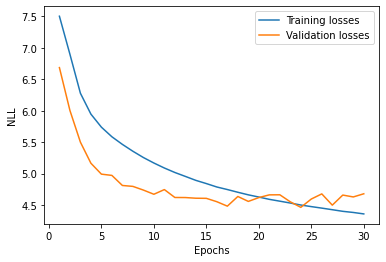

In [23]:
plt.figure()
plt.plot(range(1, trainer.epochs + 1), trainer.train_losses, label='Training losses')
plt.plot(range(1, trainer.epochs + 1), trainer.val_losses, label='Validation losses')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

# **Evaluation**

 - Now that you have trained your model and got satisfactory validation NLL on the single token prediction task, you can evaluate the generations you created too
 - We will use the perplexity metric to evaluate generations using a large language model available through the OpenAI API. Read the handout for instructions on how to sign up for the API and obtain and API key.
 - Once you add credits to your account, run this cell to get the perplexity.
 - You will submit this perplexity value for grading the generation component of this homework.
 - A perplexity of under **1400** will give you full credit on the generation part.

Change only the **submission_run_id**, **submission_epoch**, and **api_key** in the following cell

In [24]:
# DO NOT CHANGE THE CODE IN THIS CELL EXCEPT submission_run_id, submission_epoch, AND api_key
# PLEASE BE HONEST IN REPORTING THE PERPLEXITY VALUE!
# WE WILL RANDOMLY CHECK SOME SUBMISSIONS USING THE SAME CODE AS THIS AND A BIG DIFFERENCE IN PERPLEXITY WILL RESULT IN AN AIV.

import openai

# Add you submission_run_id and submission_epoch here --------------------------------------------------
# Fill the run id and epoch number to be used for submission.
# You will use the same run id and epoch number to generate the handin.

submission_run_id = run_id # TODO
submission_epoch = 24 # TODO

# --------------------------------------------------------------

n_tests = 128

with open(os.path.join('./experiments', submission_run_id, 'generated-texts-{}-test.txt'.format(submission_epoch)), 'r', encoding='utf-8') as f:
    generated = list(f)

assert len(generated) == n_tests
for item in generated:
    assert type(item) is str

parsed_generated = []

for text in generated:
    start_index = text.index("<sos>")
    temp = text[start_index+6:]
    generation_start_index = temp.index("| ")
    parsed_text = temp[:generation_start_index] + temp[generation_start_index+2:]
    parsed_text = parsed_text.replace("<eol>", "\n")
    parsed_generated.append(parsed_text)

def perplexity(text, modelname):
    """Compute the perplexity of the provided text."""
    completion = openai.Completion.create(
        model=modelname,
        prompt=text,
        logprobs=0,
        max_tokens=0,
        temperature=1.0,
        echo=True)
    token_logprobs = completion['choices'][0]['logprobs']['token_logprobs']
    ll = np.mean([i for i in token_logprobs if i is not None])
    ppl = np.exp(-ll)
    return ppl

# Add you API key here --------------------------------------------------
# However, delete the key from the notebook before creating the handin.
# REMEMBER: ALWAYS KEEP YOUR API KEYS AND SECRETS SECURE.

openai.api_key = '' # TODO

# --------------------------------------------------------------

modelname = 'text-embedding-ada-002'

perps = [perplexity(text, modelname) for text in tqdm(parsed_generated)]
avg_perp = np.mean(perps)

# Report this number when running the makefile to create the handin
print("Your mean perplexity for generated sequences: {}".format(avg_perp))

  0%|          | 0/128 [00:00<?, ?it/s]

100%|██████████| 128/128 [00:24<00:00,  5.20it/s]

Your mean perplexity for generated sequences: 1300.4517978788508
